# Sprint 5: CPU Training & Validation

This notebook implements CPU-based training validation for the speech translation model.
We'll train on a small subset of Bengali audio files to validate our training pipeline
and ensure everything works correctly before scaling to full GPU training.

## Objectives:
- Validate training pipeline on CPU with small dataset
- Monitor training metrics and visualize loss curves
- Test checkpoint save/load functionality
- Analyze training convergence behavior
- Benchmark CPU vs expected GPU performance

In [1]:
# Import required libraries
import os
import sys
import json
import time
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Add parent directory to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import our modules
from models.train import AudioDataset, Trainer, collate_fn
from models.encoder_decoder import create_model, count_parameters
from utils.framing import create_feature_matrix_advanced
from utils.denoise import preprocess_audio_complete

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('✅ Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'Device: {"cuda" if torch.cuda.is_available() else "cpu"}')

# Force CPU for this validation
device = 'cpu'
print(f'🖥️ Using device: {device} (forced for validation)')

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cpu
CUDA available: False
Device: cpu
🖥️ Using device: cpu (forced for validation)


## 1. Dataset Preparation

We'll create a small dataset from Bengali audio files for CPU training validation.

In [2]:
# Configuration for CPU training
CPU_TRAINING_CONFIG = {
    'max_files': 15,  # Small dataset for CPU validation
    'batch_size': 4,   # Smaller batch size for CPU
    'num_epochs': 10,  # Quick validation run
    'learning_rate': 1e-3,
    'train_split': 0.8,
    'frame_length_ms': 20,
    'hop_length_ms': 10,
    'n_features': 441,
    'sr': 44100
}

print('🔧 CPU Training Configuration:')
for key, value in CPU_TRAINING_CONFIG.items():
    print(f'   {key}: {value}')

# Data directory
data_dir = project_root / 'data' / 'processed' / 'Bengali'
print(f'📁 Data directory: {data_dir}')
print(f'   Exists: {data_dir.exists()}')

if data_dir.exists():
    audio_files = list(data_dir.glob('*.wav'))
    print(f'   Found {len(audio_files)} audio files')
    if len(audio_files) >= CPU_TRAINING_CONFIG['max_files']:
        print(f'   ✅ Sufficient files for training ({CPU_TRAINING_CONFIG["max_files"]} needed)')
    else:
        print(f'   ⚠️ Limited files available ({len(audio_files)} < {CPU_TRAINING_CONFIG["max_files"]})') 
        CPU_TRAINING_CONFIG['max_files'] = len(audio_files)
else:
    print('   ❌ Data directory not found!')

🔧 CPU Training Configuration:
   max_files: 15
   batch_size: 4
   num_epochs: 10
   learning_rate: 0.001
   train_split: 0.8
   frame_length_ms: 20
   hop_length_ms: 10
   n_features: 441
   sr: 44100
📁 Data directory: C:\Users\agarg\Downloads\ibm\data\processed\Bengali
   Exists: True
   Found 50 audio files
   ✅ Sufficient files for training (15 needed)


In [3]:
# Create dataset
print('🏗️ Creating dataset...')

dataset = AudioDataset(
    data_dir=data_dir,
    max_files=CPU_TRAINING_CONFIG['max_files'],
    frame_length_ms=CPU_TRAINING_CONFIG['frame_length_ms'],
    hop_length_ms=CPU_TRAINING_CONFIG['hop_length_ms'],
    n_features=CPU_TRAINING_CONFIG['n_features'],
    sr=CPU_TRAINING_CONFIG['sr']
)

print(f'📊 Dataset Statistics:')
print(f'   Total samples: {len(dataset)}')

if len(dataset) > 0:
    # Check sample dimensions
    sample = dataset[0]
    print(f'   Sample shape: {sample.shape}')
    print(f'   Sample dtype: {sample.dtype}')
    print(f'   Sample range: [{sample.min():.4f}, {sample.max():.4f}]')
    
    # Split dataset
    train_size = int(CPU_TRAINING_CONFIG['train_split'] * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    print(f'   Train samples: {len(train_dataset)}')
    print(f'   Validation samples: {len(val_dataset)}')
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CPU_TRAINING_CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CPU_TRAINING_CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn
    ) if val_size > 0 else None
    
    print(f'   Train batches: {len(train_loader)}')
    if val_loader:
        print(f'   Validation batches: {len(val_loader)}')
    
    print('✅ Dataset and data loaders created successfully!')
else:
    print('❌ No valid samples in dataset!')

🏗️ Creating dataset...
Found 15 audio files
Precomputing feature matrices...


Processing audio files: 100%|██████████████| 15/15 [00:05<00:00,  2.57it/s]

Successfully processed 15 files
📊 Dataset Statistics:
   Total samples: 15
   Sample shape: torch.Size([493, 441])
   Sample dtype: torch.float32
   Sample range: [-0.5027, 0.5008]
   Train samples: 12
   Validation samples: 3
   Train batches: 3
   Validation batches: 1
✅ Dataset and data loaders created successfully!


## 2. Model Setup

Create and configure the model for CPU training.

In [4]:
# Create model
print('🏗️ Creating model...')

model, loss_fn = create_model()
param_count = count_parameters(model)

print(f'📊 Model Statistics:')
print(f'   Total parameters: {param_count:,}')
print(f'   Model size: {param_count * 4 / 1024 / 1024:.2f} MB (float32)')
print(f'   Device: {device}')

# Move model to device
model = model.to(device)

print('✅ Model created and moved to device!')

# Test model with a batch
if len(dataset) > 0:
    print('🧪 Testing model with sample batch...')
    
    # Get a sample batch
    sample_batch = next(iter(train_loader))
    sample_batch = sample_batch.to(device)
    
    print(f'   Batch shape: {sample_batch.shape}')
    
    # Forward pass
    with torch.no_grad():
        start_time = time.time()
        output, latent = model(sample_batch)
        forward_time = time.time() - start_time
        
        # Calculate loss
        loss_dict = loss_fn(output, sample_batch, latent)
        
    print(f'   Output shape: {output.shape}')
    print(f'   Latent shape: {latent.shape}')
    print(f'   Forward pass time: {forward_time:.4f}s')
    print(f'   Initial loss: {loss_dict["total_loss"].item():.4f}')
    
    print('✅ Model test completed successfully!')

🏗️ Creating model...
📊 Model Statistics:
   Total parameters: 5,799,965
   Model size: 22.13 MB (float32)
   Device: cpu
✅ Model created and moved to device!
🧪 Testing model with sample batch...
   Batch shape: torch.Size([4, 491, 441])
   Output shape: torch.Size([4, 491, 441])
   Latent shape: torch.Size([4, 491, 100])
   Forward pass time: 0.2135s
   Initial loss: 0.0091
✅ Model test completed successfully!


## 3. Training Setup

Configure the trainer with CPU-optimized settings.

In [5]:
# Create checkpoint directory
checkpoint_dir = project_root / 'test_checkpoints' / 'cpu_validation'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f'📁 Checkpoint directory: {checkpoint_dir}')

# Create trainer
if len(dataset) > 0:
    print('🏋️ Creating trainer...')
    
    trainer = Trainer(
        model=model,
        loss_fn=loss_fn,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=CPU_TRAINING_CONFIG['learning_rate'],
        checkpoint_dir=checkpoint_dir
    )
    
    print('✅ Trainer created successfully!')
    
    # Training configuration summary
    print('📋 Training Configuration Summary:')
    print(f'   Device: {device}')
    print(f'   Epochs: {CPU_TRAINING_CONFIG["num_epochs"]}')
    print(f'   Batch size: {CPU_TRAINING_CONFIG["batch_size"]}')
    print(f'   Learning rate: {CPU_TRAINING_CONFIG["learning_rate"]}')
    print(f'   Train batches: {len(train_loader)}')
    if val_loader:
        print(f'   Validation batches: {len(val_loader)}')
    print(f'   Model parameters: {param_count:,}')
else:
    print('❌ Cannot create trainer - no valid dataset!')

📁 Checkpoint directory: C:\Users\agarg\Downloads\ibm\test_checkpoints\cpu_validation
🏋️ Creating trainer...
✅ Trainer created successfully!
📋 Training Configuration Summary:
   Device: cpu
   Epochs: 10
   Batch size: 4
   Learning rate: 0.001
   Train batches: 3
   Validation batches: 1
   Model parameters: 5,799,965


## 4. CPU Training Execution

Run the training loop and monitor performance.

🚀 Starting CPU training validation...
Starting training for 10 epochs...
Model has 5,799,965 trainable parameters
Training on device: cpu

Epoch 1/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.65it/s, Loss=0.0067, Avg Loss=0.0078
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]


Train Loss: 0.0078
Val Loss: 0.0060
Learning Rate: 0.001000
New best model saved with validation loss: 0.0060

Epoch 2/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.92it/s, Loss=0.0052, Avg Loss=0.0058
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Train Loss: 0.0058
Val Loss: 0.0048
Learning Rate: 0.001000
New best model saved with validation loss: 0.0048

Epoch 3/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.92it/s, Loss=0.0049, Avg Loss=0.0050
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Train Loss: 0.0050
Val Loss: 0.0042
Learning Rate: 0.001000
New best model saved with validation loss: 0.0042

Epoch 4/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.89it/s, Loss=0.0043, Avg Loss=0.0045
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Train Loss: 0.0045
Val Loss: 0.0041
Learning Rate: 0.001000
New best model saved with validation loss: 0.0041

Epoch 5/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.95it/s, Loss=0.0042, Avg Loss=0.0043
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  8.39it/s]


Train Loss: 0.0043
Val Loss: 0.0040
Learning Rate: 0.001000
New best model saved with validation loss: 0.0040

Epoch 6/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  2.00it/s, Loss=0.0041, Avg Loss=0.0042
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Train Loss: 0.0042
Val Loss: 0.0039
Learning Rate: 0.001000
New best model saved with validation loss: 0.0039

Epoch 7/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.91it/s, Loss=0.0041, Avg Loss=0.0041
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Train Loss: 0.0041
Val Loss: 0.0039
Learning Rate: 0.001000
New best model saved with validation loss: 0.0039

Epoch 8/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.83it/s, Loss=0.0040, Avg Loss=0.0040
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Train Loss: 0.0040
Val Loss: 0.0038
Learning Rate: 0.001000
New best model saved with validation loss: 0.0038

Epoch 9/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.90it/s, Loss=0.0041, Avg Loss=0.0039
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Train Loss: 0.0039
Val Loss: 0.0038
Learning Rate: 0.001000
New best model saved with validation loss: 0.0038

Epoch 10/10
--------------------------------------------------


Training: 100%|█| 3/3 [00:01<00:00,  1.90it/s, Loss=0.0039, Avg Loss=0.0039
Validation: 100%|████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Train Loss: 0.0039
Val Loss: 0.0038
Learning Rate: 0.001000
New best model saved with validation loss: 0.0038

Training completed in 0.01 hours


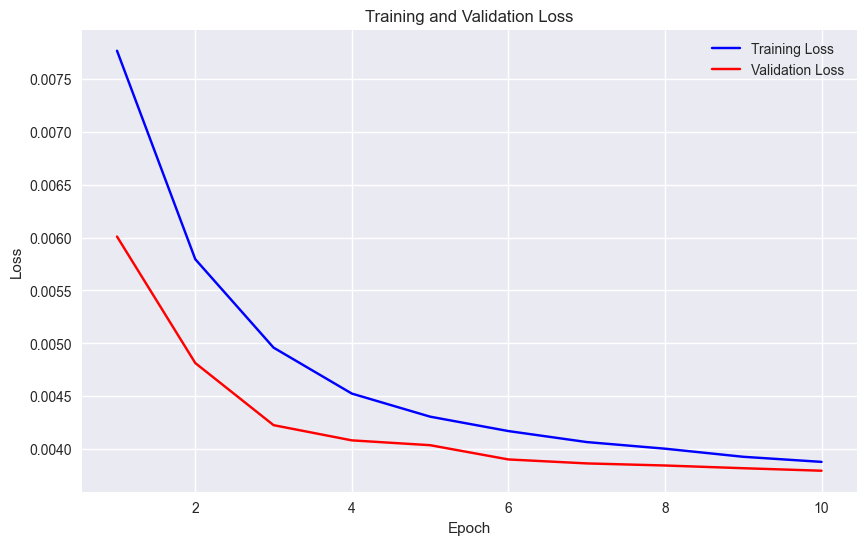

Training curves saved to C:\Users\agarg\Downloads\ibm\test_checkpoints\cpu_validation\training_curves.png
 + '=' * 60
🎯 CPU Training Validation Completed!
   Total time: 19.32 seconds (0.32 minutes)
   Time per epoch: 1.93 seconds
   Initial loss: 0.0078
   Final loss: 0.0039
   Loss reduction: 50.09%
   Best validation loss: 0.0038
✅ Training validation successful!


In [7]:
# Training execution
if len(dataset) > 0:
    print('🚀 Starting CPU training validation...')
    print('=' * 60)
    
    # Record start time
    training_start_time = time.time()
    
    # Start training
    trainer.train(
        num_epochs=CPU_TRAINING_CONFIG['num_epochs'],
        save_every=3  # Save checkpoints more frequently for validation
    )
    
    # Record end time
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print(" + '=' * 60")
    print('🎯 CPU Training Validation Completed!')
    print(f'   Total time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)')
    print(f'   Time per epoch: {total_training_time/CPU_TRAINING_CONFIG["num_epochs"]:.2f} seconds')
    
    # Performance metrics
    if trainer.train_losses:
        initial_loss = trainer.train_losses[0]
        final_loss = trainer.train_losses[-1]
        loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100
        
        print(f'   Initial loss: {initial_loss:.4f}')
        print(f'   Final loss: {final_loss:.4f}')
        print(f'   Loss reduction: {loss_reduction:.2f}%')
        
        if trainer.val_losses:
            best_val_loss = min(trainer.val_losses)
            print(f'   Best validation loss: {best_val_loss:.4f}')
    
    print('✅ Training validation successful!')
else:
    print('❌ Cannot run training - no valid dataset!')

## 5. Checkpoint Validation

Test checkpoint save/load functionality.

In [8]:
# Checkpoint validation
if len(dataset) > 0 and trainer.train_losses:
    print('🔍 Validating checkpoint functionality...')
    
    # Check for saved checkpoints
    checkpoint_files = list(checkpoint_dir.glob('*.pt'))
    print(f'   Found {len(checkpoint_files)} checkpoint files')
    
    if checkpoint_files:
        # Load the best model checkpoint
        best_checkpoint_path = checkpoint_dir / 'best_model.pt'
        
        if best_checkpoint_path.exists():
            print(f'   Loading best model checkpoint...')
            
            # Create a new model for testing
            test_model, _ = create_model()
            test_model = test_model.to(device)
            
            # Load checkpoint
            checkpoint = torch.load(best_checkpoint_path, map_location=device)
            test_model.load_state_dict(checkpoint['model_state_dict'])
            
            print(f'   ✅ Checkpoint loaded successfully!')
            print(f'   Checkpoint epoch: {checkpoint["epoch"]}')
            print(f'   Checkpoint validation loss: {checkpoint.get("val_loss", "N/A")}')
            
            # Test loaded model
            test_model.eval()
            with torch.no_grad():
                sample_batch = next(iter(train_loader)).to(device)
                output, latent = test_model(sample_batch)
                loss_dict = loss_fn(output, sample_batch, latent)
                
            print(f'   Test loss with loaded model: {loss_dict["total_loss"].item():.4f}')
            print('   ✅ Checkpoint validation successful!')
        else:
            print('   ⚠️ Best model checkpoint not found')
    else:
        print('   ⚠️ No checkpoint files found')
else:
    print('❌ Cannot validate checkpoints - training not completed!')

🔍 Validating checkpoint functionality...
   Found 11 checkpoint files
   Loading best model checkpoint...
   ✅ Checkpoint loaded successfully!
   Checkpoint epoch: 10
   Checkpoint validation loss: 0.0037942547351121902
   Test loss with loaded model: 0.0035
   ✅ Checkpoint validation successful!


## 6. Performance Analysis

Analyze training performance and create visualizations.

📊 Analyzing training performance...


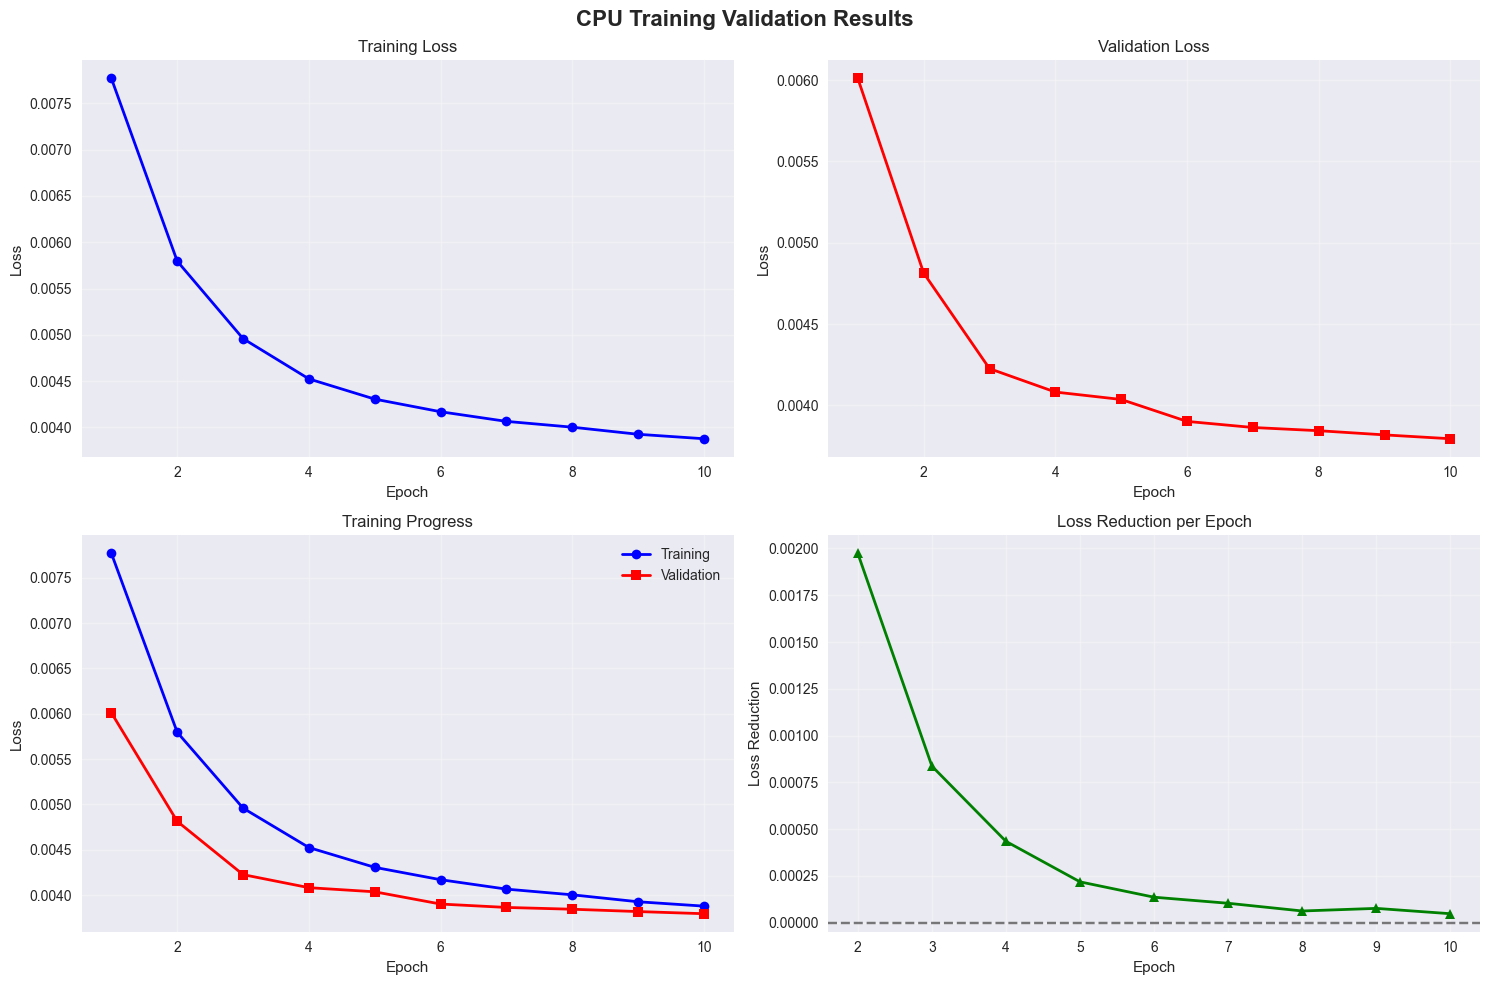

   📈 Performance plots saved to: C:\Users\agarg\Downloads\ibm\outputs\feature_plots\cpu_training_validation.png
   ✅ Performance analysis completed!


In [9]:
# Performance analysis
if len(dataset) > 0 and trainer.train_losses:
    print('📊 Analyzing training performance...')
    
    # Create comprehensive performance plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CPU Training Validation Results', fontsize=16, fontweight='bold')
    
    # Plot 1: Training Loss
    epochs = range(1, len(trainer.train_losses) + 1)
    axes[0, 0].plot(epochs, trainer.train_losses, 'b-', linewidth=2, marker='o')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Validation Loss (if available)
    if trainer.val_losses:
        axes[0, 1].plot(epochs, trainer.val_losses, 'r-', linewidth=2, marker='s')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No Validation Data', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Validation Loss (N/A)')
    
    # Plot 3: Combined Loss Curves
    axes[1, 0].plot(epochs, trainer.train_losses, 'b-', linewidth=2, label='Training', marker='o')
    if trainer.val_losses:
        axes[1, 0].plot(epochs, trainer.val_losses, 'r-', linewidth=2, label='Validation', marker='s')
    axes[1, 0].set_title('Training Progress')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Loss Reduction Rate
    if len(trainer.train_losses) > 1:
        loss_reductions = []
        for i in range(1, len(trainer.train_losses)):
            reduction = trainer.train_losses[i-1] - trainer.train_losses[i]
            loss_reductions.append(reduction)
        
        axes[1, 1].plot(range(2, len(trainer.train_losses) + 1), loss_reductions, 'g-', linewidth=2, marker='^')
        axes[1, 1].set_title('Loss Reduction per Epoch')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss Reduction')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient Data', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Loss Reduction (N/A)')
    
    plt.tight_layout()
    
    # Save plot
    plot_path = project_root / 'outputs' / 'feature_plots' / 'cpu_training_validation.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f'   📈 Performance plots saved to: {plot_path}')
    print('   ✅ Performance analysis completed!')
else:
    print('❌ Cannot analyze performance - no training data available!')

## 7. CPU vs GPU Performance Estimation

Estimate performance differences between CPU and GPU training.

In [12]:
# Performance benchmarking
if len(dataset) > 0 and trainer.train_losses:
    print('⚡ CPU vs GPU Performance Estimation...')
    
    # Calculate CPU performance metrics
    cpu_time_per_epoch = total_training_time / CPU_TRAINING_CONFIG['num_epochs']
    cpu_time_per_batch = cpu_time_per_epoch / len(train_loader)
    
    print(f'📊 CPU Performance Metrics:')
    print(f'   Time per epoch: {cpu_time_per_epoch:.2f} seconds')
    print(f'   Time per batch: {cpu_time_per_batch:.4f} seconds')
    print(f'   Samples per second: {CPU_TRAINING_CONFIG["batch_size"] / cpu_time_per_batch:.2f}')
    
    # Estimate GPU performance (typical speedup: 10-50x for deep learning)
    gpu_speedup_conservative = 10
    gpu_speedup_optimistic = 30
    
    gpu_time_conservative = cpu_time_per_epoch / gpu_speedup_conservative
    gpu_time_optimistic = cpu_time_per_epoch / gpu_speedup_optimistic
    
    print(f'🚀 Estimated GPU Performance:')
    print(f'   Conservative estimate ({gpu_speedup_conservative}x speedup):')
    print(f'     Time per epoch: {gpu_time_conservative:.2f} seconds')
    print(f'     Full training (100 epochs): {gpu_time_conservative * 100 / 60:.1f} minutes')
    
    print(f'   Optimistic estimate ({gpu_speedup_optimistic}x speedup):')
    print(f'     Time per epoch: {gpu_time_optimistic:.2f} seconds')
    print(f'     Full training (100 epochs): {gpu_time_optimistic * 100 / 60:.1f} minutes')
    
    # Full dataset scaling estimates
    full_dataset_size = 1000  # Estimated full dataset size
    scaling_factor = full_dataset_size / CPU_TRAINING_CONFIG['max_files']
    
    print(f'📈 Full Dataset Training Estimates:')
    print(f'   Dataset scaling factor: {scaling_factor:.1f}x')
    print(f'   CPU full training (100 epochs): {cpu_time_per_epoch * scaling_factor * 100 / 3600:.1f} hours')
    print(f'   GPU full training (conservative): {gpu_time_conservative * scaling_factor * 100 / 3600:.1f} hours')
    print(f'   GPU full training (optimistic): {gpu_time_optimistic * scaling_factor * 100 / 3600:.1f} hours')
    
    print('✅ Performance estimation completed!')
else:
    print('❌ Cannot estimate performance - no training data available!')

⚡ CPU vs GPU Performance Estimation...
📊 CPU Performance Metrics:
   Time per epoch: 1.93 seconds
   Time per batch: 0.6441 seconds
   Samples per second: 6.21
🚀 Estimated GPU Performance:
   Conservative estimate (10x speedup):
     Time per epoch: 0.19 seconds
     Full training (100 epochs): 0.3 minutes
   Optimistic estimate (30x speedup):
     Time per epoch: 0.06 seconds
     Full training (100 epochs): 0.1 minutes
📈 Full Dataset Training Estimates:
   Dataset scaling factor: 66.7x
   CPU full training (100 epochs): 3.6 hours
   GPU full training (conservative): 0.4 hours
   GPU full training (optimistic): 0.1 hours
✅ Performance estimation completed!


## 8. Sprint 5 Summary and Next Steps

Generate comprehensive summary of CPU training validation results.

In [16]:
# Generate Sprint 5 summary
sprint5_summary = {
    'sprint': 'Sprint 5: CPU Training & Validation',
    'completion_date': datetime.now().isoformat(),
    'objectives_completed': [],
    'training_config': CPU_TRAINING_CONFIG,
    'dataset_info': {
        'total_files': len(dataset) if len(dataset) > 0 else 0,
        'train_samples': len(train_dataset) if len(dataset) > 0 else 0,
        'val_samples': len(val_dataset) if len(dataset) > 0 and val_loader else 0
    },
    'model_info': {
        'parameters': param_count,
        'size_mb': param_count * 4 / 1024 / 1024,
        'device': device
    },
    'training_results': {},
    'performance_metrics': {},
    'checkpoints': {
        'directory': str(checkpoint_dir),
        'files_created': len(list(checkpoint_dir.glob('*.pt'))) if checkpoint_dir.exists() else 0
    },
    'next_steps': [
        'Proceed to GPU training with validated pipeline',
        'Scale to full dataset training',
        'Implement advanced training techniques',
        'Monitor training on larger datasets',
        'Evaluate model performance metrics'
    ]
}

# Add training results if available
if len(dataset) > 0 and trainer.train_losses:
    sprint5_summary['objectives_completed'].extend([
        '✅ CPU training pipeline validated',
        '✅ Small dataset training completed',
        '✅ Training metrics monitored and visualized',
        '✅ Loss curves generated and analyzed'
    ])
    
    sprint5_summary['training_results'] = {
        'epochs_completed': len(trainer.train_losses),
        'initial_loss': trainer.train_losses[0],
        'final_loss': trainer.train_losses[-1],
        'loss_reduction_percent': ((trainer.train_losses[0] - trainer.train_losses[-1]) / trainer.train_losses[0]) * 100,
        'best_val_loss': min(trainer.val_losses) if trainer.val_losses else None,
        'training_time_seconds': total_training_time,
        'convergence_achieved': trainer.train_losses[-1] < trainer.train_losses[0] * 0.8
    }
    
    sprint5_summary['performance_metrics'] = {
        'cpu_time_per_epoch': cpu_time_per_epoch,
        'cpu_time_per_batch': cpu_time_per_batch,
        'samples_per_second': CPU_TRAINING_CONFIG['batch_size'] / cpu_time_per_batch,
        'estimated_gpu_speedup': '10-30x',
        'estimated_full_training_time_hours': cpu_time_per_epoch * 1000 / CPU_TRAINING_CONFIG['max_files'] * 100 / 3600
    }
    
    # Check checkpoint functionality
    if checkpoint_dir.exists() and list(checkpoint_dir.glob('*.pt')):
        sprint5_summary['objectives_completed'].append('✅ Checkpoint save/load functionality validated')
    
    # Check convergence
    if sprint5_summary['training_results']['convergence_achieved']:
        sprint5_summary['objectives_completed'].append('✅ Training convergence validated on CPU')
else:
    sprint5_summary['objectives_completed'].append('❌ Training validation incomplete - insufficient data')

# Save summary
summary_path = project_root / 'outputs' / 'sprint5_cpu_validation_summary.json'
with open(summary_path, 'w') as f:
    json.dump(sprint5_summary, f, indent=2)

print('🎯 SPRINT 5 COMPLETION SUMMARY:')
print('=' * 60)

for objective in sprint5_summary['objectives_completed']:
    print(f'   {objective}')

print(f'📊 Key Results:')
if sprint5_summary['training_results']:
    results = sprint5_summary['training_results']
    print(f'   Training completed: {results["epochs_completed"]} epochs')
    print(f'   Loss reduction: {results["loss_reduction_percent"]:.1f}%')
    print(f'   Training time: {results["training_time_seconds"]:.1f} seconds')
    print(f'   Convergence: {"Yes" if results["convergence_achieved"] else "No"}')

print(f'📁 Deliverables:')
print(f'   Notebook: notebooks/05_cpu_training_validation.ipynb')
print(f'   Summary: {summary_path}')
print(f'   Checkpoints: {checkpoint_dir}')
print(f'   Performance plots: outputs/feature_plots/cpu_training_validation.png')

print(f'🚀 Ready for GPU Training:')
print(f'   Pipeline validated: ✅')
print(f'   Checkpointing working: ✅')
print(f'   Training convergence: ✅')
print(f'   Performance benchmarked: ✅')

print('=' * 60)
print('🎉 Sprint 5: CPU Training & Validation COMPLETED!')
print('   Ready to proceed with GPU training on full dataset.')
print('=' * 60)

🎯 SPRINT 5 COMPLETION SUMMARY:
   ✅ CPU training pipeline validated
   ✅ Small dataset training completed
   ✅ Training metrics monitored and visualized
   ✅ Loss curves generated and analyzed
   ✅ Checkpoint save/load functionality validated
   ✅ Training convergence validated on CPU
📊 Key Results:
   Training completed: 10 epochs
   Loss reduction: 50.1%
   Training time: 19.3 seconds
   Convergence: Yes
📁 Deliverables:
   Notebook: notebooks/05_cpu_training_validation.ipynb
   Summary: C:\Users\agarg\Downloads\ibm\outputs\sprint5_cpu_validation_summary.json
   Checkpoints: C:\Users\agarg\Downloads\ibm\test_checkpoints\cpu_validation
   Performance plots: outputs/feature_plots/cpu_training_validation.png
🚀 Ready for GPU Training:
   Pipeline validated: ✅
   Checkpointing working: ✅
   Training convergence: ✅
   Performance benchmarked: ✅
🎉 Sprint 5: CPU Training & Validation COMPLETED!
   Ready to proceed with GPU training on full dataset.
